# Republican or Democrat? A Model-Based Machine Learning Approach for Classifying Tweets

## Authors

Mads Yar

## Table of contents

1. Introduction
    - Download
    - Imports
2. Helper Functions
3. Data Preprocessing
4. Models
    - Bayesian Logistic Regression (BLR)
    - Bayesian Hierarchical Model (BHM)
5. Training and Evaluation
6. Visualisation
7. Saving
8. Closing remarks

## 1. Introduction

In this day and age, the political landscape changes quick so understanding and classifying political opinions is an interesting task. This project presents a model-driven approach to try and classify tweets into two political affiliations: Republican and Democrat. Hence, we have used a dataset of tweets from the 2020 US presidental election. Additionally, in this project, a probabilistic modeling framework, called Pyro, has been used to construct our Model-Based Machine Learning approach. Here, we have used Bayesian methods to try and capture the  uncertainty and variability in social media text data. The choice of a model-driven approach was because we wanted to make our own model by combining multiple models into one instead of simply applying a standard classification algorithm. Specifically, this project implements and evaluates two models:

1. **Bayesian Logistic Regression (BLR)** - a traditional Bayesian classifier that serves as a baseline for comparison.
2. **Adapted Bayesian Hierarchical Model (BHM)** - our custom model which integrates multiple probabilistic models, such as a Gaussian Mixture Model (GMM) and Latent Dirichlet Allocation (LDA), into one framework. With this adaptation, we are trying to get the model to explicitly capture interactions between sentiment, topics, and structural tweet features. This has been done to see if it is possible to better capture the political discourse on Twitter.

The project begins with a preprocessing of the text data, so the raw tweets are transformed into a format suitable for probabilistic modeling. Each model is then implemented in Pyro and trained using Stochastic Variational Inference. The models are then evaluated using different metrics such as accuracy, ROC-curves and loss to see how they perform. BLR was implemented to work as a baseline to see how our adapted BHM model compares to a traditional Bayesian classifier.

This notebook is structured to be fully self-explanatory, so the reader is guided through each step of the process, from data preparation to model evaluation and visualization. This approach not only ensures reproducibility but also allows for a clear understanding of the model-driven approach to machine learning.

**Note on runtime:** Running the entire Jupyter Notebook took about 103 minutes on a PC with a 13th Gen Intel i7-13700KF CPU and an NVIDIA GeForce RTX 3070 GPU. Most of the time was spent on training and evaluation (ca. 85 minutes), followed by data preprocessing (ca. 15 minutes). So, don't be surprised if running the notebook takes a while.

### 1.a Download

For this Jupyter Notebook, we have used Python 3.12.8. Please download the below libraries needed to run this notebook.

In [1]:
# We use python 3.12.8 for this notebook
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install vaderSentiment
!pip install nbformat
!pip install torch
!pip install wordninja
!pip install emoji
!pip install pyro-ppl
!pip install seaborn
!pip install ipywidgets

  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---------------------------------------- 12.6/12.6 MB 98.8 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

   ---------------------------------------- 0/4 [pytz]
   ---------- ----------------------------- 1/4 [tzdata]
   -------------------- ------------------- 2/4 [numpy]
   -------------------- ------------------- 2/4 [numpy]
   -------------------- ------------------- 2/4 [numpy]
   -------------------- ------------------- 2/4 [numpy]
   -------------------- ------------------- 2/4 [numpy]
   -------------------- ------------------- 2/4 [numpy]
   -------------------- 

### 1.b Imports

Below, we have all the libraries which has been used for this project:

In [2]:
import os
import re
import pyro
import torch
import emoji
import random
import seaborn
import wordninja
import numpy as np
import pandas as pd
import pickle as pkl
from pyro.optim import Adam
import matplotlib.pyplot as plt
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc

To ensure that our results are consistent and reproducible, we set random seeds for PyTorch, NumPy, and Pyro.


In [3]:
# Added for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
pyro.set_rng_seed(42)

In the code in the chapters "2. Helper Functions" and "4. Models", do not worry about the yellow lines underneath `X_train` and `X_test` as they will be defined later in this Jupyter notebook. It is just the way, we have structured our Notebook to make it look more organised. Everything will run as expected if you just run every cell.

## 2. Helper Functions

In this section, we define several plotting functions to visualize model performance:

- **conf_mat:** Plots confusion matrices for each model to see each models correct and incorrect predictions.
- **train_metrics:** Visualizes training and validation metrics (loss and accuracy) over time.
- **roc_curves:** Displays ROC curves for our different models to see the difference between true positive and false positive rates.

These visualizations allow for a clear and intuitive comparison of models performances.

In [35]:
def conf_mat(models, model_names, y_true, y_preds):
    """
    Plot confusion matrices side by side for our models.
    """
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 6))
    
    if n_models == 1:
        axes = [axes] 
    
    for i, (model_name, y_pred) in enumerate(zip(model_names, y_preds)):
        cm = confusion_matrix(y_true, y_pred)
        
        seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], 
                    xticklabels=["Democrat", "Republican"], yticklabels=["Democrat", "Republican"])
        
        axes[i].set_title(f"Confusion Matrix - {model_name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
    
    plt.tight_layout()
    plt.show()

def train_metrics(training_results, model_name="Naive Bayes"):
    """
    Plot training metrics from model training:
    1. Training and validation loss in one plot
    2. Training and validation accuracy in another plot
    """
    
    train_losses = training_results["train_losses"]
    val_metrics = training_results["val_metrics"]
    train_metrics = training_results["train_metrics"]
    
    val_iterations = val_metrics["iterations"]
    
    # Sample training losses at validation iterations only
    sampled_train_losses = []
    for iter_val in val_iterations:
        if iter_val <= len(train_losses):
            sampled_train_losses.append(train_losses[iter_val - 1])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Training loss and validation loss together
    ax1.plot(val_iterations, sampled_train_losses, 'o-', 
             label="Training Loss", color="blue", markersize=6)
    
    if val_metrics["iterations"]:
        ax1.plot(val_metrics["iterations"], val_metrics["loss"], 's-', 
                 label="Validation Loss", color="red", markersize=6)
    
    ax1.set_title(f"{model_name} - Loss Metrics")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Training and validation accuracy
    if val_metrics["iterations"] and train_metrics["iterations"]:
        ax2.plot(train_metrics["iterations"], train_metrics["accuracy"], 'o-', 
                 label="Training Accuracy", color="blue", markersize=6)
        ax2.plot(val_metrics["iterations"], val_metrics["accuracy"], 's-', 
                 label="Validation Accuracy", color="green", markersize=6)
        
        ax2.set_title(f"{model_name} - Accuracy Metrics")
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Score")
        ax2.set_ylim([0, 1.05])
        ax2.grid(True, alpha=0.3)
        ax2.legend(loc="best")
    
    plt.tight_layout()
    plt.show()


def roc_curves(trained_models, feature_set=None):
    """
    Plot ROC curves for individual models.
    """
    plt.figure(figsize=(10, 8))
    
    # Plot ROC for individual models
    for model_name, trained_model in trained_models.items():
        model = trained_model["model"]
        guide = trained_model["posterior"]

        # Get the correct feature set for this model
        model_feature_set = feature_set if feature_set is not None else trained_model.get("feature_set")
        if model_name == "BLR":
            if isinstance(model_feature_set, list):
                X = torch.cat([X_test[key].unsqueeze(-1) if X_test[key].ndim == 1 else X_test[key]
                               for key in model_feature_set if key in X_test], dim=1)
            else:
                X = X_test[model_feature_set]
        elif model_name == "BHM":
            if isinstance(model_feature_set, list):
                X = {key: X_test[key] for key in model_feature_set if key in X_test}
            else:
                raise ValueError(f"BHM requires a list of feature names.")
        else:
            raise ValueError(f"Model {model_name} is not recognized.")
        
        # Generate predictions
        predictive = pyro.infer.Predictive(model, guide=guide, num_samples=500)
        with torch.no_grad():
            if isinstance(X, dict):  # For models like BHM expecting a dictionary
                predictions = predictive(X=X)
            else:
                predictions = predictive(X)
        
        # Extract predicted probabilities and plot ROC
        probs = predictions["obs_labels"].mean(dim=0).numpy()
        fpr, tpr, _ = roc_curve(y_test.numpy(), probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Individual Models and Ensemble')
    plt.legend(loc="lower right")
    plt.show()

## 3. Data Preprocessing

We begin by loading the tweet datasets for Donald Trump and Joe Biden. Here, you will need to have the two CSV files "hashtag_donaldtrump.csv" and "hashtag_joebiden.csv" in a designated folder called "data". These datasets are then combined into a single DataFrame, with an additional column indicating the target (Trump or Biden). Duplicate tweets are removed to make sure the same data is not used multiple times.

In [5]:
path = os.getcwd()

# Path for windows
if os.name == "nt":
    path_trump = path + "\\data\\hashtag_donaldtrump.csv"
    path_biden = path + "\\data\\hashtag_joebiden.csv"
else: # Path for Linux and Mac
    path_trump = path + "/data/hashtag_donaldtrump.csv"
    path_biden = path + "/data/hashtag_joebiden.csv"

df_trump = pd.read_csv(path_trump, lineterminator="\n")
df_biden = pd.read_csv(path_biden, lineterminator="\n")
df_trump["tweet_about"] = "trump"
df_biden["tweet_about"] = "biden"
df = pd.concat([df_trump, df_biden], ignore_index=True)
df = df.drop_duplicates()

Here, we clean the tweet by removing:
- URLs, mentions, and hashtags.
- Emojis and all characters which are not in the alphabet.
- Extra whitespace.
- All text is converted to lowercase.

This is done to ensure the tweets are in a consistent format for when we train our models. 

In [6]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", lambda m: " ".join(wordninja.split(m.group())), text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df["clean_text"] = df["tweet"].astype(str).apply(clean_text)

We prepare the labels for classification:
- Tweets mentioning Trump are labeled as "1" (Republican).
- Tweets mentioning Biden are labeled as "0" (Democrat).
- A tweet cannot be labeled as both.


We use "frequent names" for Trump and Biden to identify and label tweets as Republican or Democrat. This approach is necessary because tweets often reference political figures using different names that does not directly mention Republican or Democrat. For example, a tweet may use terms like MAGA or Sleepy Joe, which clearly indicate political affiliation without directly stating it. By using different names associated with each candidate, we ensure that tweets are labeled accurately, even when the meaning is indirect. This method improves the quality of the labeled data which will lead to better model performance, as it captures more of the pull picture of political references found in social media text.

In [7]:
frequent_names_trump = r"\b(?:" + "|".join([
    "Trump", "Donald Trump", "@realDonaldTrump", "The Donald", "45",
    "Donald J. Trump", "DJT", "The Trump Administration", "Trumpster",
    "POTUS", "@POTUS", "Republican", "Republicans", "GOP", "MAGA",
    "Right Wing", "the Right", "The Right Wing"
]) + r")\b"

frequent_names_biden = r"\b(?:" + "|".join([
    "Biden", "Joe Biden", "@JoeBiden", "The Biden", "46",
    "Joseph R. Biden", "JRB", "The Biden Administration", "Bidenster",
    "Joe", "Joseph", "Joseph Biden", "Sleepy Joe", "Uncle Joe",
    "Dems", "Democrat", "Democrats", "Left Wing", "The Left", "The Left Wing"
]) + r")\b"

mask_trump = df["clean_text"].str.contains(frequent_names_trump, case=False, na=False)
mask_biden = df["clean_text"].str.contains(frequent_names_biden, case=False, na=False)

df["label"] = 0
df.loc[mask_trump & ~mask_biden, "label"] = 1

To ensure that our dataset is balanced, we randomly sample 600,000 tweets for each class (Republican and Democrat). This avoids class imbalance, which could bias when training our models. 

In [8]:
democrat_df = df[df["label"] == 0].sample(n=600000, random_state=42, replace=False)
republican_df = df[df["label"] == 1].sample(n=600000, random_state=42, replace=False)
df = pd.concat([democrat_df, republican_df], ignore_index=True).sample(frac=1, random_state=42)

We split the data into training and test sets (80% training, 20% testing) which is standard machine learning practice.

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

We use VADER to extract sentiment features from the cleaned tweets:
- Positive, Negative, Neutral, and Compound sentiment scores are calculated.
- These features provide additional information for model training.

In [10]:
analyzer = SentimentIntensityAnalyzer()
for dset in [train_df, test_df]:
    sentiment_scores = dset["clean_text"].apply(analyzer.polarity_scores)
    dset["sentiment_pos"] = sentiment_scores.apply(lambda x: x["pos"])
    dset["sentiment_neg"] = sentiment_scores.apply(lambda x: x["neg"])
    dset["sentiment_neu"] = sentiment_scores.apply(lambda x: x["neu"])
    dset["sentiment_compound"] = sentiment_scores.apply(lambda x: x["compound"])

We define a list of custom stop words which are common political words like "trump", "biden", "democrat", and "republican" because they are mentioned so frequently that they provide almost no useful information for distinguishing between the two classes (Republican or Democrat).

In [11]:
POLITICAL_STOP_WORDS = [
    "trump", "biden", "donald", "joe", "potus", "2020", "realdonaldtrump",
    "democrat", "democrats", "republican", "republicans", "gop", "maga",
    "left", "right", "cnn", "fox", "nbc", "cbs", "kamala"
]

custom_stop_words = list(ENGLISH_STOP_WORDS) + POLITICAL_STOP_WORDS

We apply Term Frequency-Inverse Document Frequency (TF-IDF) vectorization to the cleaned tweet to convert text into numerical features. This way, we can capture word importance:
- TF-IDF is applied to both train and test sets.
- The resulting feature matrix is limited to 1,000 features for efficiency.

In [12]:
tfidf = TfidfVectorizer(max_features=1000, stop_words=custom_stop_words)
tfidf_matrix_train = tfidf.fit_transform(train_df["clean_text"])
tfidf_matrix_test = tfidf.transform(test_df["clean_text"])
tfidf_feature_names = tfidf.get_feature_names_out()

We use Latent Dirichlet Allocation (LDA) to extract topic distributions from the TF-IDF features. LDA is a generative probabilistic model that identifies hidden topics within text data by representing each document (tweet) as a mixture of topics, and each topic as a mixture of words. Hence, the purpose is to allows the models to learn about the semantics in the tweets by capturing themes that may indicate either Republican or Democrat. Here, we have done the following:
- The model is trained on the training set and applied to both train and test sets.
- Each tweet is represented by a distribution over 10 topics.

In [13]:
NUM_TOPICS = 10
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, random_state=42)
lda_output_train = lda.fit_transform(tfidf_matrix_train)
lda_output_test = lda.transform(tfidf_matrix_test)

We extract statistical features from the tweets:
- Text length (number of words).
- Unique word ratio.
- Uppercase letter ratio.
- Punctuation count (e.g., exclamation marks).
- Hashtag count.
- Mention count.

In [14]:
def add_stat_features(dset):
    dset["text_length"] = dset["clean_text"].apply(lambda x: len(x.split()))
    dset["unique_word_ratio"] = dset["clean_text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)
    dset["uppercase_ratio"] = dset["tweet"].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
    dset["punctuation_count"] = dset["tweet"].apply(lambda x: len(re.findall(r"[!?]", str(x))))
    dset["hashtag_count"] = dset["tweet"].apply(lambda x: len(re.findall(r"#\w+", str(x))))
    dset["mention_count"] = dset["tweet"].apply(lambda x: len(re.findall(r"@\w+", str(x))))

add_stat_features(train_df)
add_stat_features(test_df)

We generate topic-sentiment interaction features by combining LDA topic distributions with the compound sentiment score of each tweet. This captures how sentiment varies across different topics.

In [15]:
def make_topic_sentiment(dset, lda_output):
    arr = np.zeros((len(dset), NUM_TOPICS))
    for i in range(NUM_TOPICS):
        arr[:, i] = lda_output[:, i] * dset["sentiment_compound"].values
    return arr

topic_sentiment_train = make_topic_sentiment(train_df, lda_output_train)
topic_sentiment_test = make_topic_sentiment(test_df, lda_output_test)

We combine the final feature sets for training and testing. And they include:
- TF-IDF features
- LDA topic distributions
- Sentiment features
- Statistical features
- Topic-sentiment interaction features
- The final combined feature set

In [16]:
def get_features(dset, tfidf_mat, lda_out, topic_sent):
    sentiment_features = dset[["sentiment_pos", "sentiment_neg", "sentiment_neu", "sentiment_compound"]].values
    stat_features = dset[["text_length", "unique_word_ratio", "uppercase_ratio", "punctuation_count", "hashtag_count", "mention_count"]].values
    return {
        "tfidf": tfidf_mat.toarray(),
        "lda_topics": lda_out,
        "sentiment": sentiment_features,
        "stats": stat_features,
        "topic_sentiment": topic_sent,
        "all_features": np.hstack([
            tfidf_mat.toarray()[:, :100],
            lda_out,
            sentiment_features,
            stat_features,
            topic_sent
        ])
    }

feature_sets_train = get_features(train_df, tfidf_matrix_train, lda_output_train, topic_sentiment_train)
feature_sets_test = get_features(test_df, tfidf_matrix_test, lda_output_test, topic_sentiment_test)

We convert the feature sets and labels into PyTorch tensors to make them ready for model training.

In [17]:
tensor_features_train = {k: torch.tensor(v, dtype=torch.float32) for k, v in feature_sets_train.items()}
tensor_features_test = {k: torch.tensor(v, dtype=torch.float32) for k, v in feature_sets_test.items()}
labels_train = torch.tensor(train_df["label"].values, dtype=torch.long)
labels_test = torch.tensor(test_df["label"].values, dtype=torch.long)

print(f"Preprocessing complete. Train: {len(train_df)}, Test: {len(test_df)}")

Preprocessing complete. Train: 960000, Test: 240000


We save the processed data and feature sets as a pickle file for future use. This ensures that the same data can be reloaded without re-processing.

In [18]:
with open("processed_data_split.pkl", "wb") as f:
    pkl.dump({
        "feature_sets_train": tensor_features_train,
        "feature_sets_test": tensor_features_test,
        "labels_train": labels_train,
        "labels_test": labels_test,
        "vocabulary": tfidf.vocabulary_,
        "lda_model": lda,
        "feature_names": {
            "tfidf": tfidf_feature_names,
            "lda_topics": [f"topic_{i}" for i in range(NUM_TOPICS)],
            "sentiment": ["pos", "neg", "neu", "compound"],
            "stats": ["text_length", "unique_word_ratio", "uppercase_ratio", "punctuation_count", "hashtag_count", "mention_count"],
            "topic_sentiment": [f"topic_{i}_sentiment" for i in range(NUM_TOPICS)]
        },
        "raw_train": train_df,
        "raw_test": test_df
    }, f)

print("Data saved to processed_data_split.pkl")

Data saved to processed_data_split.pkl


In [19]:
print(f"Preprocessing complete. Saved {len(df)} tweets.")
print(f"• Democrat tweets (label=0): {sum(df['label'] == 0)}.")
print(f"• Republican tweets (label=1): {sum(df['label'] == 1)}.")

Preprocessing complete. Saved 1200000 tweets.
• Democrat tweets (label=0): 600000.
• Republican tweets (label=1): 600000.


## 4. Models

### Bayesian Logistic Regression (BLR)

In this section, we define our Bayesian Logistic Regression (BLR) model. Unlike traditional logistic regression, which learns fixed weights for the input features, Bayesian Logistic Regression treats these weights as random variables with their own probability distributions. Specifically, we define prior distributions for the weights using a standard normal distribution: $$ \mathcal{N}(0, 1) $$This means that before observing any data, we assume that each weight is most likely centered around zero with some uncertainty.

The model begins by selecting the specified feature set which can be any combination of our processed features. It then calculates the logits using a linear combination of the input features:

$$ 
\text{logits} = X \times \text{weights} + \text{bias} 
$$

These logits are transformed into probabilities using a sigmoid activation function:

$$ 
P(y = 1 \mid X) = \sigma(\text{logits}) = \frac{1}{1 + e^{-\text{logits}}} 
$$

This converts the logits into values between 0 and 1. Or in other words, it represents the probability that a given tweet is classified as "Republican" (1) rather than "Democrat" (0). During training, if labels are provided, the model treats them as observed data and calculates the likelihood using a Bernoulli distribution. This allows the model to learn which weights best map the input features to the correct class labels.

We also define a posterior function for the BLR model, which serves as a variational approximation of the posterior distribution of the model parameters. This function uses variational inference. Specifically, the function learns two key distributions:

- The weights are modeled as:

$$ 
\text{weights} \sim \mathcal{N}(\text{weights\_loc}, \text{weights\_scale}) 
$$ 

- The bias is modeled as:

$$ 
\text{bias} \sim \mathcal{N}(\text{bias\_loc}, \text{bias\_scale}) 
$$ 

In [20]:
def blr(X=None, y=None, feature_set="all_features"):
    """
    Bayesian Logistic Regression model.
    """
    X = X_train[feature_set] if X is None else X

    if y is not None:
        y = y.float()
    
    # Set priors for weights and bias
    weights = pyro.sample("weights", dist.Normal(0, 1).expand([X.shape[1]]).to_event(1))
    bias = pyro.sample("bias", dist.Normal(0, 1))
    
    # Linear combination
    logits = X @ weights + bias
    
    # Sigmoid to get probabilities
    probs = torch.sigmoid(logits)
    
    # Observe labels if provided
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs_labels", dist.Bernoulli(probs), obs=y)
        
    return probs

def blr_posterior(X=None, y=None, feature_set="all_features"):
    """Guide function for Bayesian Logistic Regression."""
    X = X_train[feature_set] if X is None else X
    
    # Variational parameters for weights
    weights_loc = pyro.param("weights_loc", torch.zeros(X.shape[1]))
    weights_scale = pyro.param("weights_scale", torch.ones(X.shape[1]), constraint=dist.constraints.positive)
    weights = pyro.sample("weights", dist.Normal(weights_loc, weights_scale).to_event(1))
    
    # Variational parameters for bias
    bias_loc = pyro.param("bias_loc", torch.tensor(0.0))
    bias_scale = pyro.param("bias_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    bias = pyro.sample("bias", dist.Normal(bias_loc, bias_scale))
    
    return weights, bias

### Bayesian Hierarchical Model (BHM)

In this section, we present our own adaptation of a Bayesian Hierarchical Model (BHM), where we designed a probabilistic model that integrates multiple probabilistic sub-models under a combined Bayesian framework. Our BHM is an original approach that combines two sub-models: a Gaussian Mixture Model (GMM) and Latent Dirichlet Allocation (LDA). Each sub-model (GMM and LDA) is not isolated but directly contributes to the final prediction. This has been implemented alongside other features such as sentiment analysis, statistical text features, and so on. This model was developed as an attempt to create a model capable of capturing complex interactions within tweet data. Our design tries to use multiple aspects of the data to see if we can provide a more nuanced representation of tweet classification.

The features, our model uses are:
- **Topic-Sentiment Features (GMM):** Captures the distribution of sentiment scores associated with different topics using a Gaussian Mixture Model (GMM).
- **Topic Distributions (LDA):** Uses LDA to model the distribution of topics for each tweet.
- **Sentiment Scores:** Directly integrates sentiment scores (positive, negative, neutral, and compound) as features, but their impact depends on the topic distributions.
- **Text Features:** Includes text length, unique word ratio, uppercase ratio, and punctuation counts.

Another aspect for our model is that we have tried to do cross-feature dependencies, which in this case are:
- **Sentiment-Topic Interaction:** The influence of sentiment scores dependent on topic distribution. This means that the model learns how sentiment varies depending on the topic context.
- **Text Feature Dependencies:** The text features are also influenced by the topics. 

The model starts with a global hyperparameter that scales the variance of the model parameters:
$$
\text{global\_scale} \sim \text{HalfCauchy}(1.0)
$$

Next step is that the GMM models the distribution of sentiment scores across topics, and assigns each tweet to one of K Gaussian clusters:
$$
\mu_k, \sigma_k \sim \mathcal{N}(0, 1), \ \text{LogNormal}(0, 0.5)
$$

Each tweet is assigned to a cluster using a categorical distribution:
$$
z \sim \text{Categorical}(\text{mixture\_weights})
$$

The LDA models the topic distribution of each tweet. And the weight of each topic is chosen from a normal distribution:
$$
\text{topic\_weights} \sim \mathcal{N}(0, \text{global\_scale})
$$

The sentiment feature is chosen through a set of weights, which are dependent on the topic distribution:
$$
\text{sentiment\_weights} \sim \mathcal{N}(0, \text{global\_scale})
$$

A separate set of weights is used to select the influence of the text features:
$$
\text{stats\_weights} \sim \mathcal{N}(0, \text{global\_scale})
$$

If the TF-IDF feature is present, they are also weighted and contributed to the final prediction:
$$
\text{tfidf\_weights} \sim \mathcal{N}(0, \text{global\_scale})
$$


From here, the final logits are calculated by combining the contributions of each model component:
- **GMM:** The sum of the cluster means for each tweet.
- **LDA:** The weighted sum of topic distributions.
- **Sentiment:** The interaction between sentiment scores and topic weights.
- **Statistical Features:** The weighted sum of the text features.
- **TF-IDF (Optional):** The weighted sum of TF-IDF values.

The final combined logits are calculated as:
$$
\text{logits} = \text{logits\_gmm} + \text{logits\_lda} + \text{sentiment\_effect} + \text{logits\_stats} + \text{logits\_tfidf}
$$

These logits are then converted to probabilities using a sigmoid function:
$$
P(y = 1 \mid X) = \sigma(\text{logits}) = \frac{1}{1 + e^{-\text{logits}}}
$$

Where again, it represents the probability that a given tweet is classified as "Republican" (1) rather than "Democrat" (0)

We also defined a posterior function for our BHM model, which serves as a variational approximation of the posterior distribution of the model parameters. It again, uses  variational inference. 



In [ ]:
def bhm(X=None, y=None, num_topics=10, K=3): 
    """ 
    Enhanced Bayesian Hierarchical Model with GMM, LDA, and cross-feature dependencies.
    """
    # Extract feature sets 
    gmm_features = X_train["topic_sentiment"] if X is None else X.get("topic_sentiment")
    lda_features = X_train["lda_topics"] if X is None else X.get("lda_topics")
    sentiment = X_train["sentiment"] if X is None else X.get("sentiment")
    stats = X_train["stats"] if X is None else X.get("stats")
    tfidf_features = X_train["tfidf"] if X is None and "tfidf" in X_train else X.get("tfidf")

    batch_size = gmm_features.shape[0]
    
    # Global hyperparameter 
    global_scale = pyro.sample("global_scale", dist.HalfCauchy(1.0))
    
    # GMM
    mixture_weights = pyro.sample("mixture_weights", dist.Dirichlet(torch.ones(K)))
    
    with pyro.plate("K", K):
        mu = pyro.sample("mu", dist.Normal(0, 1).expand([gmm_features.shape[1]]).to_event(1))
        sigma = pyro.sample("sigma", dist.LogNormal(0, 0.5).expand([gmm_features.shape[1]]).to_event(1)) + 1e-6

    with pyro.plate("data", batch_size):
        expanded_weights = mixture_weights.expand(batch_size, K)
        z = pyro.sample("z", dist.Categorical(expanded_weights))
        gmm_cluster_means = mu[z]
        gmm_cluster_stds = sigma[z]
        pyro.sample("obs_gmm", dist.Normal(gmm_cluster_means, gmm_cluster_stds).to_event(1), obs=gmm_features)
    
    # Weights
    topic_weights = pyro.sample("topic_weights", dist.Normal(0, global_scale).expand([num_topics]).to_event(1)).reshape(-1) 
    sentiment_weights = pyro.sample("sentiment_weights", dist.Normal(0, global_scale).expand([4, num_topics]).to_event(2))
    stats_weights = pyro.sample("stats_weights", dist.Normal(0, global_scale).expand([stats.shape[1]]).to_event(1))
    
    # Calculate Logits
    logits_gmm = gmm_cluster_means.sum(dim=1) 
    logits_lda = torch.matmul(lda_features, topic_weights)
    
    # Sentiment
    sentiment_topic_interaction = torch.matmul(sentiment_weights, topic_weights).squeeze(0)  
    sentiment_effect = torch.matmul(sentiment, sentiment_topic_interaction) 
    
    # Influence of statistical features
    stats_weights = stats_weights.squeeze(0)  
    logits_stats = torch.matmul(stats, stats_weights)   
    
    # TF-IDF
    logits_tfidf = 0  
    
    if tfidf_features is not None:
        tfidf_weights = pyro.sample("tfidf_weights", dist.Normal(0, global_scale).expand([tfidf_features.shape[1]]).to_event(1))
        logits_tfidf = torch.matmul(tfidf_features, tfidf_weights)
    
    # Final logits
    logits = logits_gmm + logits_lda + sentiment_effect + logits_stats + logits_tfidf
    
    
    probs = torch.sigmoid(logits)
    
    with pyro.plate("labels", batch_size):
        pyro.sample("obs_labels", dist.Bernoulli(probs), obs=y)
        
    return probs


def bhm_posterior(X=None, y=None, num_topics=10, K=3):
    """ 
    Posterior function for the Bayesian Hierarchical Model.
    """
    if X is None:
        X = {
            "topic_sentiment": X_train["topic_sentiment"],
            "lda_topics": X_train["lda_topics"],
            "sentiment": X_train["sentiment"],
            "stats": X_train["stats"],
            "tfidf": X_train["tfidf"] 
        }
    
    batch_size = X["topic_sentiment"].shape[0]
    
    global_scale = pyro.sample("global_scale", dist.HalfCauchy(0.1))
    
    # GMM
    mixture_weights_concentration = pyro.param("mixture_weights_concentration", torch.ones(K), constraint=dist.constraints.positive)
    mixture_weights = pyro.sample("mixture_weights", dist.Dirichlet(mixture_weights_concentration))
    
    with pyro.plate("K", K):
        mu_loc = pyro.param("mu_loc", torch.zeros(K, X["topic_sentiment"].shape[1]))
        mu_scale = pyro.param("mu_scale", torch.ones(K, X["topic_sentiment"].shape[1]), constraint=dist.constraints.positive)
        mu = pyro.sample("mu", dist.Normal(mu_loc, mu_scale).to_event(1))
        
        sigma_loc = pyro.param("sigma_loc", torch.zeros(K, X["topic_sentiment"].shape[1]))
        sigma_scale = pyro.param("sigma_scale", 0.1 * torch.ones(K, X["topic_sentiment"].shape[1]), constraint=dist.constraints.positive)
        sigma = pyro.sample("sigma", dist.LogNormal(sigma_loc, sigma_scale).to_event(1))
    
    # Variational distribution for cluster assignment
    with pyro.plate("data", batch_size):
        z_probs = pyro.param(f"z_probs_{batch_size}", torch.ones(batch_size, K) / K, constraint=dist.constraints.simplex)
        z = pyro.sample("z", dist.Categorical(z_probs))
    
    # LDA
    topic_weights_loc = pyro.param("topic_weights_loc", torch.zeros(num_topics))
    topic_weights_scale = pyro.param("topic_weights_scale", torch.ones(num_topics), constraint=dist.constraints.positive)
    topic_weights = pyro.sample("topic_weights", dist.Normal(topic_weights_loc, topic_weights_scale).to_event(1))
    
    # Sentiment weights
    sentiment_weights_loc = pyro.param("sentiment_weights_loc", torch.zeros(4, num_topics))
    sentiment_weights_scale = pyro.param("sentiment_weights_scale", torch.ones(4, num_topics), constraint=dist.constraints.positive)
    sentiment_weights = pyro.sample("sentiment_weights", dist.Normal(sentiment_weights_loc, sentiment_weights_scale).to_event(2))
    
    # Stats weights
    stats_weights_loc = pyro.param("stats_weights_loc", torch.zeros(X["stats"].shape[1]))
    stats_weights_scale = pyro.param("stats_weights_scale", torch.ones(X["stats"].shape[1]), constraint=dist.constraints.positive)
    stats_weights = pyro.sample("stats_weights", dist.Normal(stats_weights_loc, stats_weights_scale).to_event(1))
    
    # TF-IDF weights
    if "tfidf" in X:
        tfidf_weights_loc = pyro.param("tfidf_weights_loc", torch.zeros(X["tfidf"].shape[1]))
        tfidf_weights_scale = pyro.param("tfidf_weights_scale", torch.ones(X["tfidf"].shape[1]),
                                    constraint=dist.constraints.positive)
        tfidf_weights = pyro.sample("tfidf_weights",
                                dist.Normal(tfidf_weights_loc, tfidf_weights_scale).to_event(1))

## 5. Training and Evaluation

In this section, we train and evaluate our two models using Stochastic Variational Inference (SVI). Both models are trained using a function called `train_model` and evaluated using a function called `evaluate_model`.

We begin by loading the preprocessed data that we saved in our processing chapter. This data includes training and testing feature sets, as well as the corresponding labels for classification. The features are stored as tensors which makes them compatible with our Pyro models.

In [23]:
# Load split data 
with open("processed_data_split.pkl", "rb") as f:
    data = pkl.load(f)

X_train = data["feature_sets_train"]
X_test = data["feature_sets_test"]
y_train = data["labels_train"]
y_test = data["labels_test"]
feature_names = data["feature_names"]

The training process is managed by the `train_model` function using SVI. SVI is a form of variational inference that is well-suited to complex Bayesian models like ours. The training process is structured as follows:

- Before training begins, we clear any existing Pyro parameter values using `pyro.clear_param_store()` to ensure a fresh start.
- The training data is split into training and validation sets. This split is essential for monitoring the model’s performance on unseen data during training, which helps prevent overfitting.
- The model and posterior functions are specified for training. If the model is the Bayesian Hierarchical Model (BHM), we ensure that the correct feature set is used. For the Bayesian Logistic Regression (BLR), the feature set is also specified.
- We use the `ClippedAdam` optimizer, which is a variant of the Adam optimizer with gradient clipping. This prevents large gradient values from derailing the training.
- The training process runs for a specified number of iterations, with the loss (negative ELBO) calculated at each step. The Evidence Lower Bound (ELBO) is a standard loss function for variational inference, where a lower loss indicates a better model.
- At intervals (controlled by `eval_every`), the model’s performance is evaluated on the validation set:
  - We calculate validation loss and cap it at a specified maximum value to prevent extreme values from distorting the plot.
  - The model’s predictions are evaluated using accuracy and AUC (Area Under the Curve) metrics.
  - If the validation accuracy improves, we reset a patience counter. If it does not improve for a set number of intervals (patience), training stops early.
- The training process tracks both training and validation losses, as well as accuracy and AUC. This allows us to visualize the model’s learning progress.

In [24]:
def train_model(model, posterior, feature_set=None, num_iterations=1000, lr=0.005, clip_norm=5.0,
                validation_fraction=0.2, eval_every=10, patience=7, verbose=True, loss_cap=50):
    """
    Train a Pyro model using SVI with ClippedAdam optimizer for stability.
    Tracks both training loss and validation metrics throughout training.
    Also tracks training accuracy at validation intervals.
    Optionally caps loss values to avoid spikes in plots.

    Args:
        model: The Pyro model to train.
        posterior: The posterior function for the model.
        feature_set: The feature set to use for training.
        num_iterations: Number of training iterations.
        lr: Learning rate for the optimizer.
        clip_norm: Gradient clipping norm.
        validation_fraction: Fraction of data to use for validation.
        eval_every: Frequency of evaluation during training.
        patience: Early stopping patience.
        verbose: Whether to print training progress.
        loss_cap: Cap for loss values.
    """
    # Clear param store before training
    pyro.clear_param_store()

    # Split training data to create a validation set
    train_size = int((1 - validation_fraction) * len(y_train))

    # Prepare data based on model type
    if model == bhm or posterior == bhm_posterior:
        if feature_set is None:
            feature_set = ["topic_sentiment", "lda_topics", "sentiment", "stats"]
        X_train_split, X_val_split = {}, {}
        for key in feature_set:
            if key in X_train:
                X_train_split[key] = X_train[key][:train_size]
                X_val_split[key] = X_train[key][train_size:]
        X, X_val = X_train_split, X_val_split
    else:
        if feature_set is None:
            feature_set = "all_features"
        if isinstance(feature_set, list):
            X = torch.cat([X_train[key] for key in feature_set], dim=1)[:train_size]
            X_val = torch.cat([X_train[key] for key in feature_set], dim=1)[train_size:]
        else:
            X = X_train[feature_set][:train_size]
            X_val = X_train[feature_set][train_size:]
    
    # Prepare labels
    y_train_split = y_train[:train_size].float()
    y_val_split = y_train[train_size:].float()

    
    optimizer = pyro.optim.ClippedAdam({"lr": lr, "clip_norm": clip_norm})
    elbo = Trace_ELBO(num_particles=5, strict_enumeration_warning=False)
    svi = SVI(model, posterior, optimizer, loss=elbo)

    train_losses = []
    train_metrics = {"iterations": [], "accuracy": [], "auc": []}
    val_metrics = {"iterations": [], "loss": [], "accuracy": [], "auc": []}
    best_val_acc, best_val_loss, patience_counter = 0.0, float('inf'), 0

    # Training loop
    for i in range(num_iterations):
        loss = svi.step(X, y_train_split)
        normalized_loss = loss / train_size
        capped_train_loss = min(normalized_loss, loss_cap)
        train_losses.append(capped_train_loss)

        # Validation step
        if (i + 1) % eval_every == 0 or i == 0 or i == num_iterations - 1:
            predictive = Predictive(model, guide=posterior, num_samples=200)
            val_loss = elbo.loss(model, posterior, X_val, y_val_split) / len(y_val_split)
            capped_val_loss = min(val_loss, loss_cap)
            
            # Validation metrics
            with torch.no_grad():
                val_predictions = predictive(X_val, None)
                train_predictions = predictive(X, None)
            
            # Calculate accuracy and AUC
            if "obs_labels" in val_predictions:
                val_probs = val_predictions["obs_labels"].mean(dim=0)
                val_preds = (val_probs > 0.5).float()
                val_acc = accuracy_score(y_val_split.numpy(), val_preds.numpy())
                val_auc = roc_auc_score(y_val_split.numpy(), val_probs.numpy()) if len(y_val_split.unique()) > 1 else 0.5

                train_probs = train_predictions["obs_labels"].mean(dim=0)
                train_preds = (train_probs > 0.5).float()
                train_acc = accuracy_score(y_train_split.numpy(), train_preds.numpy())
                train_auc = roc_auc_score(y_train_split.numpy(), train_probs.numpy()) if len(y_train_split.unique()) > 1 else 0.5

                train_metrics["iterations"].append(i + 1)
                train_metrics["accuracy"].append(train_acc)
                train_metrics["auc"].append(train_auc)

                val_metrics["iterations"].append(i + 1)
                val_metrics["loss"].append(capped_val_loss)
                val_metrics["accuracy"].append(val_acc)
                val_metrics["auc"].append(val_auc)

                # Print metrics
                if verbose:
                    print(f"[{i+1}/{num_iterations}] Train Loss: {capped_train_loss:.4f} | "
                          f"Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f} | "
                          f"Val Loss: {capped_val_loss:.4f} | Val Acc: {val_acc:.4f} | "
                          f"Val AUC: {val_auc:.4f}")

                # Early stopping
                if val_acc > best_val_acc:
                    best_val_acc, best_val_loss, patience_counter = val_acc, capped_val_loss, 0
                else:
                    patience_counter += 1

                if patience_counter >= patience and i > 200:
                    if verbose:
                        print(f"Early stopping at iteration {i+1} due to no improvement.")
                    break
        
        # Print training loss every 50 iterations
        elif (i + 1) % 50 == 0 and verbose:
            print(f"[{i+1}/{num_iterations}] Train Loss: {capped_train_loss:.4f}")

    return {
        "svi": svi,
        "train_losses": train_losses,
        "train_metrics": train_metrics,
        "val_metrics": val_metrics,
        "model": model,
        "posterior": posterior,
        "feature_set": feature_set,
        "final_train_loss": capped_train_loss,
        "best_val_loss": best_val_loss,
        "best_val_acc": best_val_acc
    }


Once training is complete, we evaluate the trained models using the `evaluate_model` function:
- The function uses Pyro’s `Predictive` class to generate predictions from the trained model. This allows us to directly obtain posterior samples of the model’s predictions.
- The predictions are converted into probabilities using the mean of the posterior samples, and then into binary class labels (0 for Democrat, 1 for Republican).
- We calculate a range of evaluation metrics, including accuracy, precision, recall, F1 score, and AUC. These metrics provide a comprehensive view of model performance.
- The function also generates a confusion matrix and a classification report. Thus making it easier to understand where the model performs well and where it struggles.

In [25]:
def evaluate_model(trained_model, feature_set=None, threshold=0.5):
    """
    Evaluate a trained Pyro model.

    Args:
        trained_model: The trained model object.
        feature_set: The feature set to use for evaluation.
        threshold: Probability threshold for classification.
    """
    model = trained_model["model"]
    posterior = trained_model["posterior"]
    
    # Dynamically prepare features based on the model type
    if model == bhm or posterior == bhm_posterior:
        if feature_set is None:
            feature_set = ["topic_sentiment", "lda_topics", "sentiment", "stats"]
        
        # Use only the specified features
        X = {key: X_test[key] for key in feature_set if key in X_test}
    else:
        if feature_set is None:
            feature_set = "all_features"
        
        # If feature_set is a list, concatenate the features
        if isinstance(feature_set, list):
            X = torch.cat([X_test[key] for key in feature_set], dim=1)
        else:
            X = X_test[feature_set]

    y_float = y_test.float() 

    # Use Predictive to get posterior samples
    predictive = Predictive(model, guide=posterior, num_samples=1000)
    with torch.no_grad():
        predictions = predictive(X, None)
    
    # Extract predicted probabilities
    if "obs_labels" in predictions:
        probs = predictions["obs_labels"].mean(dim=0)
    else:
        raise ValueError("The model did not produce 'obs_labels' in predictions.")
    
    # Convert to class labels
    pred_labels = (probs > threshold).float()
    
    # Calculate metrics
    accuracy = accuracy_score(y_float.numpy(), pred_labels.numpy())
    precision = precision_score(y_float.numpy(), pred_labels.numpy(), average='weighted')
    recall = recall_score(y_float.numpy(), pred_labels.numpy(), average='weighted')
    f1 = f1_score(y_float.numpy(), pred_labels.numpy(), average='weighted')
    auc = roc_auc_score(y_float.numpy(), probs.numpy()) if len(y_float.unique()) > 1 else 0.5
    conf_matrix = confusion_matrix(y_float.numpy(), pred_labels.numpy())
    report = classification_report(y_float.numpy(), pred_labels.numpy(), 
                                   target_names=["Democrat", "Republican"], output_dict=True)

    return {
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": report,
        "probabilities": probs,
        "predictions": pred_labels,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auc": auc
    }

We begin by training our Bayesian Logistic Regression (BLR) model. This model is trained using four main feature sets: topic-sentiment features (GMM), topic distributions (LDA), sentiment scores, and the text features. The training is set to run for 2,000 iterations, with a learning rate of 0.003 and a patience of 100, meaning training stops early if there is no improvement in validation accuracy for 100 consecutive iterations.

After training, the BLR model is evaluated using the test set. The evaluation metrics are calculated to provide a clear view of how well the model generalizes to unseen data.


In [26]:
# Run Bayesian Logistic Regression
y_preds = []

print("\nRunning Bayesian Logistic Regression...")
blr_model = train_model(
    blr, 
    blr_posterior, 
    feature_set=["topic_sentiment", "lda_topics", "sentiment", "stats"], 
    num_iterations=2000, 
    lr=0.003,
    patience=100,
    eval_every=50,
    verbose=True)

blr_eval = evaluate_model(blr_model, feature_set=["topic_sentiment", "lda_topics", "sentiment", "stats"])

y_preds.append(blr_eval["predictions"].numpy())
print("\n Done with Bayesian Logistic Regression")


Running Bayesian Logistic Regression...
[1/2000] Train Loss: 5.8715 | Train Acc: 0.4935 | Train AUC: 0.4683 | Val Loss: 5.9401 | Val Acc: 0.5580 | Val AUC: 0.5887
[50/2000] Train Loss: 4.0638 | Train Acc: 0.5160 | Train AUC: 0.5512 | Val Loss: 4.9662 | Val Acc: 0.5332 | Val AUC: 0.5884
[100/2000] Train Loss: 5.6254 | Train Acc: 0.5502 | Train AUC: 0.5911 | Val Loss: 4.8504 | Val Acc: 0.5033 | Val AUC: 0.4993
[150/2000] Train Loss: 3.6245 | Train Acc: 0.5661 | Train AUC: 0.5887 | Val Loss: 3.4701 | Val Acc: 0.5133 | Val AUC: 0.5745
[200/2000] Train Loss: 4.6113 | Train Acc: 0.5689 | Train AUC: 0.5930 | Val Loss: 3.7747 | Val Acc: 0.5147 | Val AUC: 0.6056
[250/2000] Train Loss: 3.7574 | Train Acc: 0.5754 | Train AUC: 0.6037 | Val Loss: 5.6451 | Val Acc: 0.5674 | Val AUC: 0.6048
[300/2000] Train Loss: 4.0341 | Train Acc: 0.5910 | Train AUC: 0.6211 | Val Loss: 2.8907 | Val Acc: 0.5747 | Val AUC: 0.5999
[350/2000] Train Loss: 2.4777 | Train Acc: 0.5934 | Train AUC: 0.6245 | Val Loss: 2.435

Next, we train our Bayesian Hierarchical Model (BHM) using the same feature set. Like the BLR, it is trained for 2,000 iterations with the same learning rate and patience settings.

After training, the BHM model is also evaluated using the test set. This allows us to directly compare the performance of the two models.

In [27]:
# Run Hierarchical Model
print("\nRunning Hierarchical Model...")
bhm_model = train_model(
    bhm, 
    bhm_posterior, 
    feature_set=["topic_sentiment", "lda_topics", "sentiment", "stats"], 
    num_iterations=2000, 
    lr=0.003,
    patience=100,
    eval_every=50,
    verbose=True)

bhm_eval = evaluate_model(bhm_model, feature_set=["topic_sentiment", "lda_topics", "sentiment", "stats"])

y_preds.append(bhm_eval["predictions"].numpy())
print("\n Done with Bayesian Hierarchical Model")


Running Hierarchical Model...
[1/2000] Train Loss: 21.7003 | Train Acc: 0.4964 | Train AUC: 0.4796 | Val Loss: 21.8157 | Val Acc: 0.4949 | Val AUC: 0.4961
[50/2000] Train Loss: 19.3619 | Train Acc: 0.4866 | Train AUC: 0.4833 | Val Loss: 18.4465 | Val Acc: 0.4946 | Val AUC: 0.4727
[100/2000] Train Loss: 16.2345 | Train Acc: 0.5091 | Train AUC: 0.5817 | Val Loss: 17.7762 | Val Acc: 0.5168 | Val AUC: 0.5785
[150/2000] Train Loss: 15.7049 | Train Acc: 0.5111 | Train AUC: 0.5427 | Val Loss: 15.8178 | Val Acc: 0.5416 | Val AUC: 0.5902
[200/2000] Train Loss: 12.7149 | Train Acc: 0.5077 | Train AUC: 0.6025 | Val Loss: 12.9855 | Val Acc: 0.5029 | Val AUC: 0.5059
[250/2000] Train Loss: 11.4657 | Train Acc: 0.5065 | Train AUC: 0.5922 | Val Loss: 13.3903 | Val Acc: 0.5180 | Val AUC: 0.5836
[300/2000] Train Loss: 11.1142 | Train Acc: 0.5144 | Train AUC: 0.5961 | Val Loss: 10.5878 | Val Acc: 0.5127 | Val AUC: 0.5819
[350/2000] Train Loss: 7.5416 | Train Acc: 0.5103 | Train AUC: 0.6095 | Val Loss: 8

## 6. Visualisation

In this section, we will visualizing the performance of our trained models. This is done to gain insights into how well our models perform, where they excel, and where they may struggle. We use three main types of visualizations: training metrics plots, confusion matrices, and ROC curves. These visualizations provide a clear understanding of model behavior and effectiveness.

We begin by plotting the training metrics for each model by using the `train_metrics` functione. This function generates two plots for each model: a plot of training and validation loss over iterations, and a plot of training and validation accuracy. These plots provide a clear view of how the model's performance evolves during training. The loss plot allows us to monitor the model’s convergence. Then off course a decrease in loss indicates successful learning. The accuracy plot shows how well the model is learning to classify the data correctly over time.

We start with the our Bayesian Logistic Regression model:

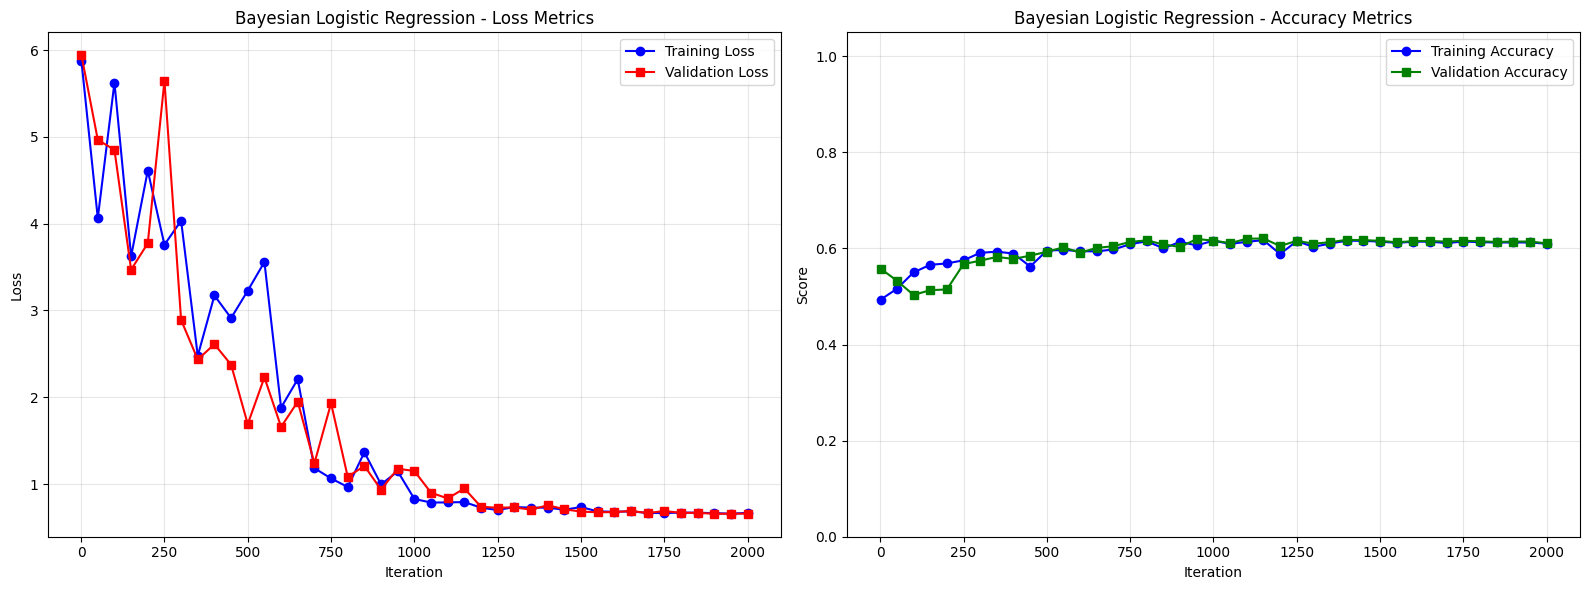

In [28]:
train_metrics(blr_model, model_name="Bayesian Logistic Regression")

The plots above visualize the loss and accuracy for both the training and validation of our Bayesian Logistic Regression (BLR) model. These plots shows how the model converges over time and how well it generalized to unseen validation data.

In the left plot, we have the loss metrics. The blue line shows the training loss, while the red line represents the validation loss. As seen in the plot, both losses decrease consistently throughout training which suggests that the model is learning in an effective way. The validation loss follows the training loss which shows that the model is not overfitting and is generalizing well. On the right plot, we show the accuracy. The blue line represents training accuracy, and the green line shows validation accuracy. Both curves increase gradually and eventually plateau around the same value, which also shows that the model maintains good generalization to the validation set.



We then continue with our Bayesian Hierarchical Model:

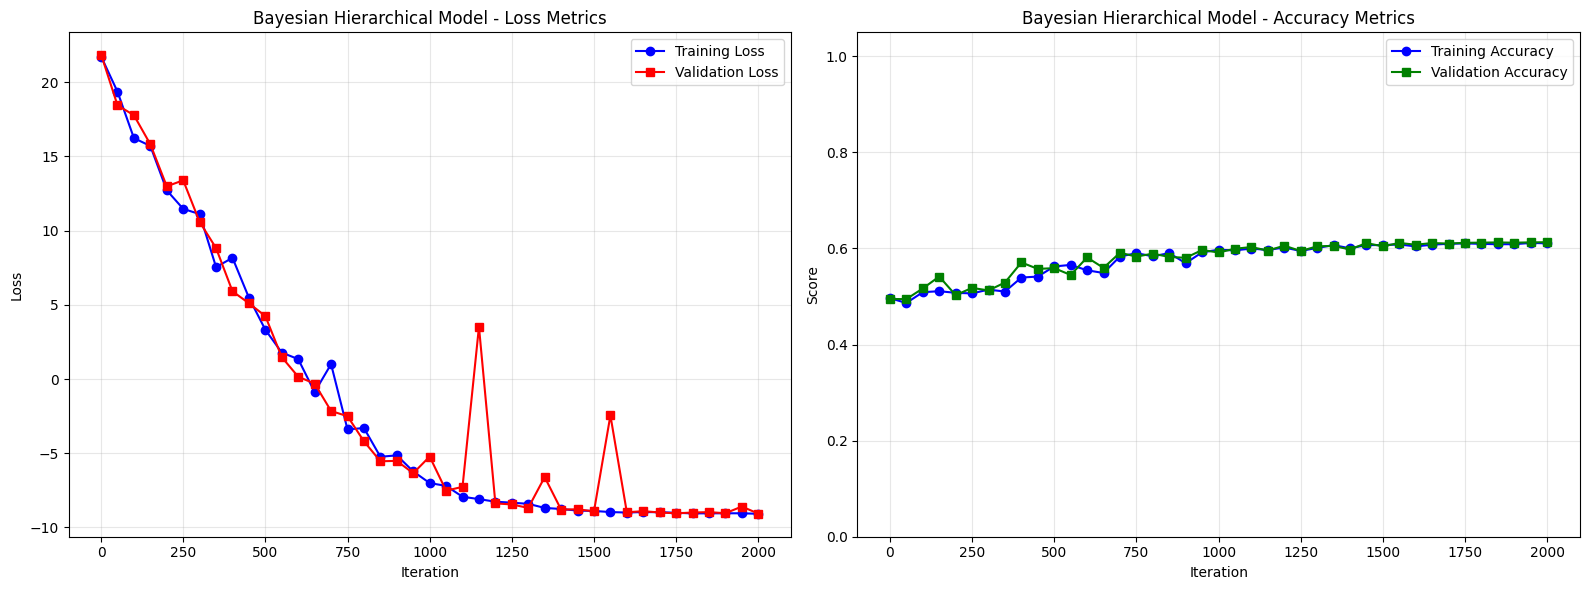

In [29]:
train_metrics(bhm_model, model_name="Bayesian Hierarchical Model")

The plots above show the training and validation of our custom Bayesian Hierarchical Model. As with the previous model, we plot both the loss and accuracy for the training and validation over time.

In the left plot, we see the loss curves. The blue line shows the training loss, while the red line shows the validation loss. Overall, both losses are decreasing at a fast rate, which shows that the model is learning effectively. While the training loss continues to decrease without any big spikes, the validation loss contains a few spikes. However, the model recovers quickly after each spike, showing that the learning remains stable overall.

In the right plot, we see the training and validation accuracy curves. Both metrics increase and plateau at similar values around 0.61. This shows that the model is not overfitting and generalizes well to unseen validation data. Despite the model's complexity, it appears to converge consistently and performs similarly to the Bayesian Logistic Regression model in terms of classification accuracy. However, it  might need more iterations as the accurancy curves for our BHM are more upwards comparing to the BLR accuriency curves which are more flat around the 0.6 mark.


Next, we visualize the confusion matrices for our trained models using the `conf_mat` function. A confusion matrix shows the counts of true positive, true negative, false positive, and false negative predictions. This allows us to see both the overall accuracy of a model and also where it makes mistakes. For instance, a high number of false positives (predicting "Republican" when the tweet is actually "Democrat") would indicate a specific problem with the model’s predictions. By generating confusion matrices for each model, we can see if one model is consistently better than the other in correctly classifying the tweets:

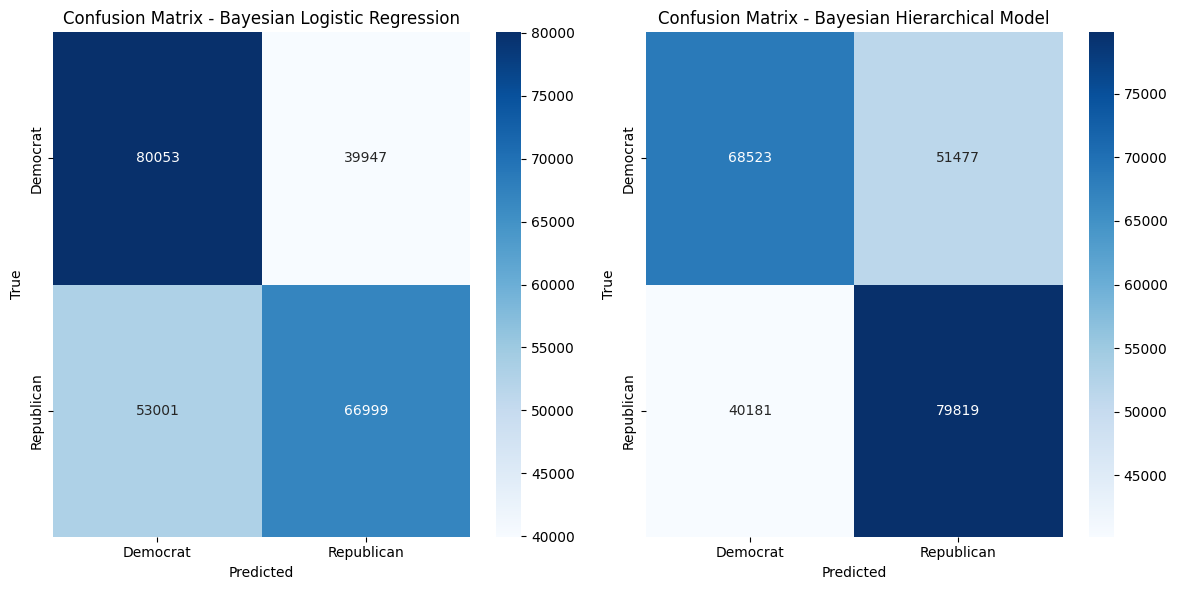

In [33]:
y_preds = [blr_eval["predictions"].numpy(), bhm_eval["predictions"].numpy()]

conf_mat(
    [blr_eval["confusion_matrix"], bhm_eval["confusion_matrix"]], 
    model_names=["Bayesian Logistic Regression", "Bayesian Hierarchical Model"], 
    y_true=y_test.numpy(), 
    y_preds=y_preds)

The confusion matrices above tell us how the models perform across each class. The Bayesian Logistic Regression (BLR) model shows good performance on Democratic tweets, wheree it is correctly classifying 80,053 out of 120,000. However, it struggles more with Republican tweets, where it is misclassifying 53,001 of them. On the other hand, the Bayesian Hierarchical Model (BHM) shows a slightly more balanced classification. it is classifying a higher number of Republican tweets (79,819) while maintaining a higher correct number of correctly predicted Democratic tweets. This suggests that the BHM is better at capturing the underlying structure of the data. This is most likely due to its added complexity and cross-feature interactions. Overall, the BHM slightly outperforms the BLR by offering more balanced classification.

Finally, we use ROC curves to further evaluate model performance. ROC curves shows a model’s ability to distinguish between classes by plotting the true positive rate against the false positive rate. If the curve is going across the plot diagonally it shows random guessing. A value closer to 1.0, towards the true positive rate, shows perfect classification. And vice versa with the false positive rate:

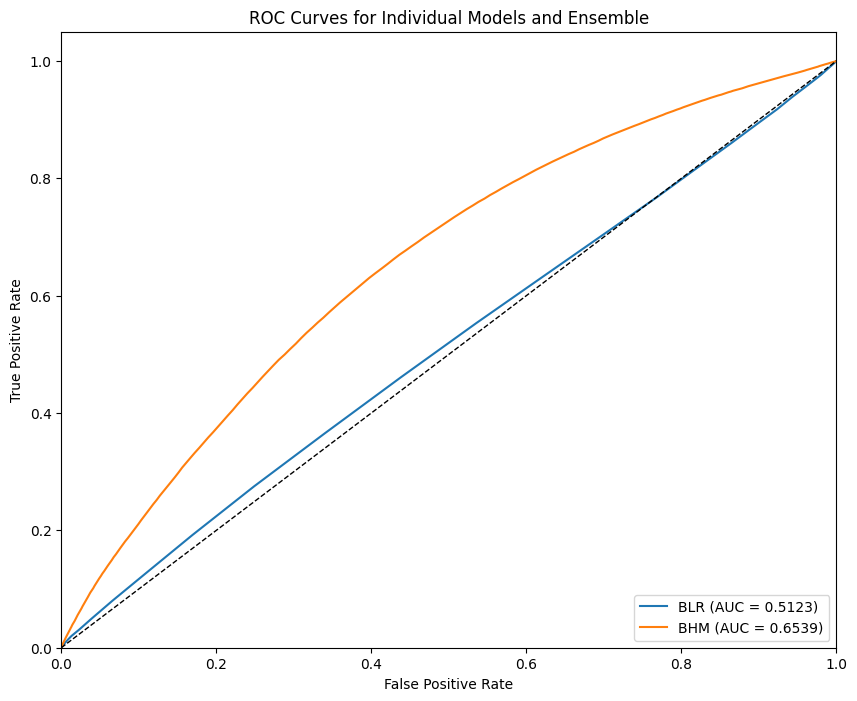

In [34]:
# Plot ROC curves
roc_curves(
    trained_models={
        "BLR": blr_model,
        "BHM": bhm_model
    },
    feature_set=["topic_sentiment", "lda_topics", "sentiment", "stats"]
)


Additionally, Area Under the Curve (AUC) is another way to evaluate how well a model distinguishes between classes. AUC values closer to 1 indicate better performance. As shown in the plot, the BHM has a much higher AUC and ROC curve compareed to the BLR. This shows that it is significantly better at choosing between Democrat and Republican tweets. This further supports the conclusion that our custom BHM are better than our BLR to capture more informative patterns in the data.

## 7. Saving  

In this section, we save our trained model alonside their training and evaluation metrics.

The below code block does the following:

- It takes a specified save directory as input.
- Checks if specified directory exists. If not, it will create the directory with subfolders for model, training, evaluation and training.
- Then it will navigates to the appropriate subdirectories for model, training and evaluation and save everything in their respective folders.


In [ ]:
def directory(base_dir="Saved Results"):
    """
    Create a new save directory with an incrementing number (Save 1, Save 2, ...).
    """
    os.makedirs(base_dir, exist_ok=True)
    
    # Get all existing "Save N" directories
    existing_dirs = [d for d in os.listdir(base_dir) if d.startswith("Save")]
    existing_numbers = [int(d.split(" ")[1]) for d in existing_dirs if d.split(" ")[1].isdigit()]
    
    # Calculate the next save number
    next_number = max(existing_numbers) + 1 if existing_numbers else 1
    new_save_dir = os.path.join(base_dir, f"Save {next_number}")
    
    # Create the new save directory structure
    models_dir = os.path.join(new_save_dir, "Models")
    results_dir = os.path.join(new_save_dir, "Results")
    training_dir = os.path.join(results_dir, "Training")
    evaluation_dir = os.path.join(results_dir, "Evaluation")
    
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(training_dir, exist_ok=True)
    os.makedirs(evaluation_dir, exist_ok=True)
    
    return models_dir, training_dir, evaluation_dir

models_dir, training_dir, evaluation_dir = directory()

blr_model.pop("svi", None)
bhm_model.pop("svi", None)

# Save the training
with open(os.path.join(training_dir, "blr_model_results.pkl"), "wb") as f:
    pkl.dump(blr_model, f)

with open(os.path.join(training_dir, "bhm_model_results.pkl"), "wb") as f:
    pkl.dump(bhm_model, f)

# Save the evaluations
with open(os.path.join(evaluation_dir, "blr_eval_results.pkl"), "wb") as f:
    pkl.dump(blr_eval, f)

with open(os.path.join(evaluation_dir, "bhm_eval_results.pkl"), "wb") as f:
    pkl.dump(bhm_eval, f)

# Save the trained model 
torch.save({"model": blr, "params": pyro.get_param_store().get_state()}, os.path.join(models_dir, "blr_params.pt"))
torch.save({"model": bhm, "params": pyro.get_param_store().get_state()}, os.path.join(models_dir, "bhm_params.pt"))

print(f"Models and results have been saved successfully in the Saved Results directory.")


Models and results have been saved successfully in the Saved Results directory.


Here, we have defined a function which can load our saved results from our saved results folder:

In [ ]:
def save(save_dir):
    """
    Load saved training and evaluation results from a specified save directory.
    """
    # Check if exists
    if not os.path.exists(save_dir):
        raise FileNotFoundError(f"The specified save directory does not exist: {save_dir}")
    
    train_dir = os.path.join(save_dir, "Results", "Training")
    eval_dir = os.path.join(save_dir, "Results", "Evaluation")

    print(f"Loading saved results from: {save_dir}")
    
    # Load training results
    with open(os.path.join(train_dir, "blr_model_results.pkl"), "rb") as f:
        blr_model = pkl.load(f)
    with open(os.path.join(train_dir, "bhm_model_results.pkl"), "rb") as f:
        bhm_model = pkl.load(f)

    # Load evaluation results
    with open(os.path.join(eval_dir, "blr_eval_results.pkl"), "rb") as f:
        blr_eval = pkl.load(f)
    with open(os.path.join(eval_dir, "bhm_eval_results.pkl"), "rb") as f:
        bhm_eval = pkl.load(f)

    return {
        "blr_model": blr_model, "blr_eval": blr_eval,
        "bhm_model": bhm_model, "bhm_eval": bhm_eval
    }

We then directly load the training and evaluation results for each model from the `saved_data` dictionary:

In [41]:
saved_data = save("Saved Results/Save 1")

# Access training and evaluation results
blr_train = saved_data["blr_model"]
bhm_train = saved_data["bhm_model"]

blr_eval = saved_data["blr_eval"]
bhm_eval = saved_data["bhm_eval"]

Loading saved results from: Saved Results/Save 1


Finally, we use our custom `train_metrics` function to visualize the training metrics for each model:

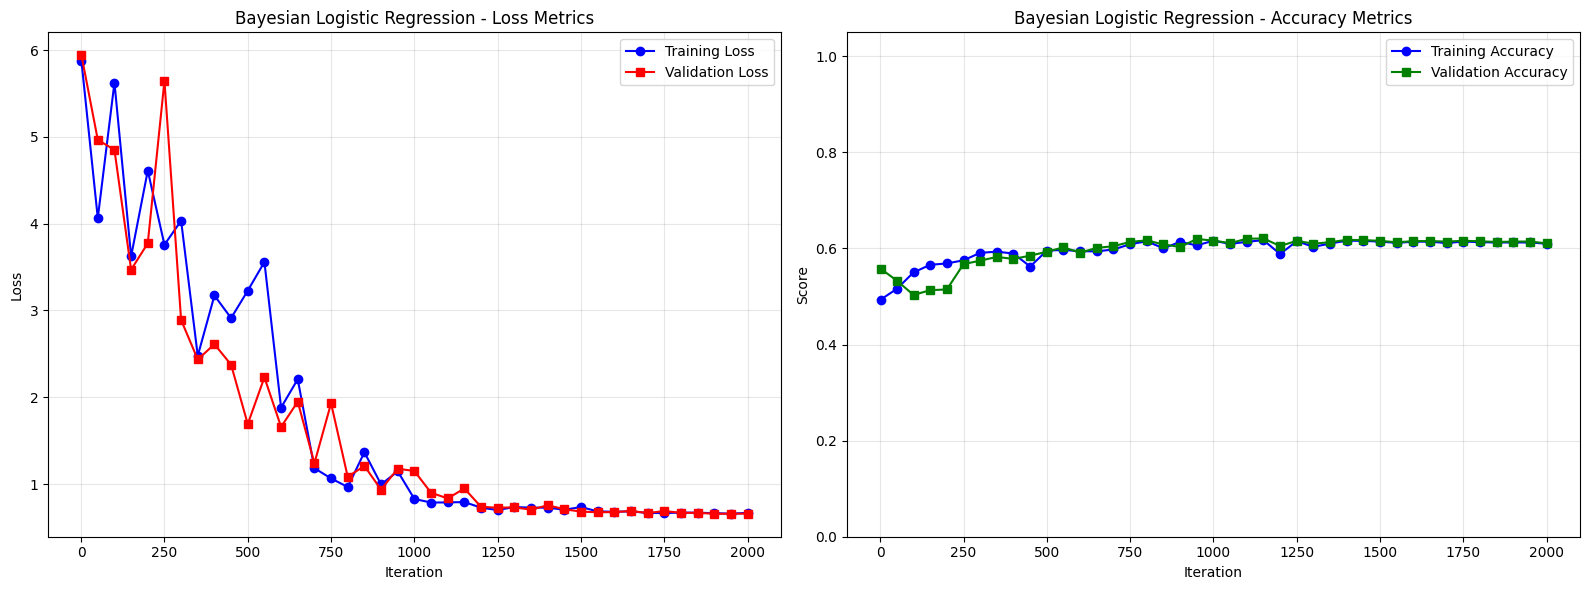

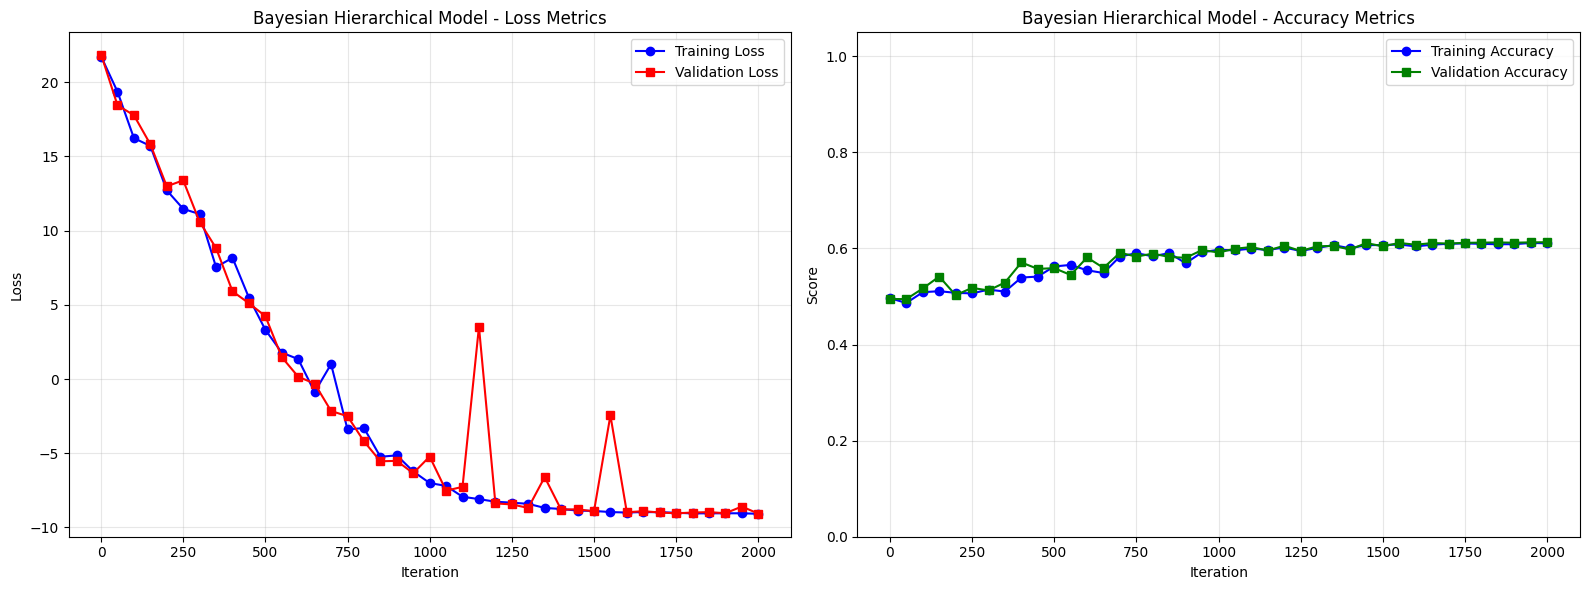

In [42]:
# Example with your plotting function (adjust the name if needed)
train_metrics(blr_train, model_name="Bayesian Logistic Regression")
train_metrics(bhm_train, model_name="Bayesian Hierarchical Model")


## Closing Remarks

In this notebook, we built and compared two probabilistic models for classifying tweets as either Democrat or Republican. We started with a Bayesian Logistic Regression (BLR) model and then designed our own Bayesian Hierarchical Model (BHM) combining GMM, LDA, and additional features.

The full pipeline included everything from preprocessing to training, evaluation, and visualisation. While BLR performed well on Democratic tweets, the BHM ended up giving a more balanced result overall. This is likely due to the added complexity and feature interactions in the BHM model.

All in all, the notebook shows how you can build and test different probabilistic models on real-world data, and how a custom model like the BHM can offer improvements when designed carefully. Lastly, it can be concluded that the entire pipeline provides a clear example of model-based machine learning in action.